# Workshop Tutorial: Optimizers

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Solving the Inverse Problem](http://phoebe-project.org/docs/2.3/tutorials/solver.ipynb)
* [Advanced: Nelder-Mead Optimizer](http://phoebe-project.org/docs/2.3/tutorials/nelder_mead.ipynb)

In [1]:
import phoebe
from phoebe import u # units
import numpy as np
# Mac users may need to turn multi-processing off
#phoebe.multiprocessing_off() 
logger = phoebe.logger('error')

In [2]:
#Load Previous Bundle
b = phoebe.open('data/synthetic/after_estimators.bundle')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


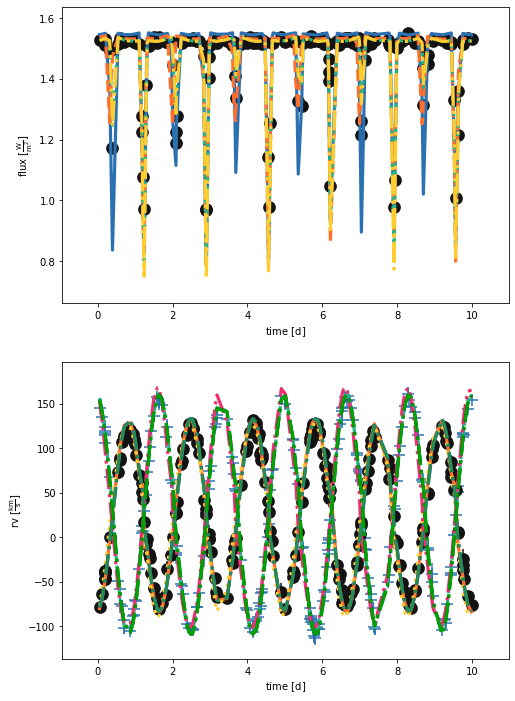

In [3]:
_ = b.plot(show=True)

In [4]:
#Create a new compute parameter set 
b.add_compute(compute='nm_fit')

<ParameterSet: 40 parameters | datasets: rv01, lc01, _default>

In [5]:
# Change fitting options for faster model computation
b.set_value('irrad_method', compute='nm_fit', value='none')
b.set_value_all('rv_method', compute='nm_fit', value='dynamical')
b.set_value_all('distortion_method', compute='nm_fit', value='sphere')

In [6]:
# Add compute phases and reduce model computation time
b.flip_constraint('compute_phases@rv01', solve_for='compute_times@rv01')
comp_phases = np.linspace(0,1,25)
b.set_value_all('compute_phases', dataset='rv01', value=comp_phases)

In [7]:
#Add optimizer
b.add_solver('optimizer.nelder_mead',  solver='nm_solver', compute='nm_fit')

<ParameterSet: 14 parameters | qualifiers: continue_from, initial_values, xatol, fatol, progress_every_niters, expose_lnprobabilities, comments, use_server, fit_parameters, priors, priors_combine, compute, adaptive, maxiter>

In [8]:
#change max iterations
b.set_value('maxiter', 25)

In [9]:
#disable lc and fit rvs
b.disable_dataset('lc01')

<ParameterSet: 18 parameters | components: binary, primary, secondary>

In [10]:
#check rv values and adjust
print(b.filter('ecc@binary'))

ParameterSet: 1 parameters
             ecc@binary@component: 0.014982550244806693


In [11]:
#set ecc to 0
b.set_value('ecc', component='binary', value=0.)
#b.flip_constraint('esinw@binary', solve_for='ecc@binary')
#b.flip_constraint('ecosw@binary', solve_for='per0@binary')
#b.flip_constraint('asini@binary', solve_for='sma@binary')

In [12]:
#set fit parameters
fit_params = ['vgamma@system', 't0_supconj@binary', 'q@binary', 'asini@binary']
b.set_value('fit_parameters', fit_params)

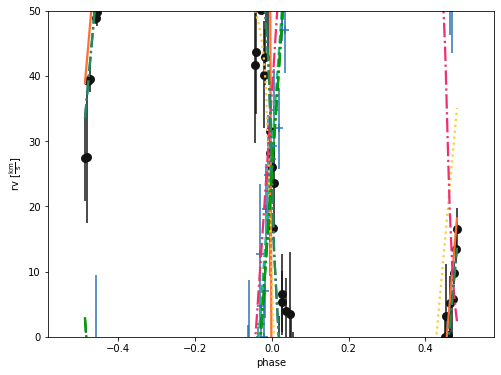

ParameterSet: 1 parameters
               q@binary@component: 0.8036935220296475


In [13]:
#determine limits
b.plot(dataset='rv01', x='phases', ylim=[0,50], show=True)
print(b.filter('q'))


In [14]:
b.add_distribution({'vgamma@system': phoebe.uniform(10,40), 
                    'q@binary': phoebe.uniform(0.6,0.9)}, distribution='dist01')

<ParameterSet: 2 parameters | qualifiers: vgamma, q>

In [15]:
print(b.filter('dist01'))
b.set_value(qualifier='priors', solver='nm_solver', value=['dist01'])

ParameterSet: 2 parameters
       vgamma@dist01@distribution: <distl.uniform low=10.0 high=40.0 unit=km / s>
            q@dist01@distribution: <distl.uniform low=0.6 high=0.9 unit=>


In [16]:
#run solver
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


<ParameterSet: 12 parameters | qualifiers: fitted_values, adopt_parameters, initial_values, fitted_units, adopt_distributions, comments, adopt_values, fitted_uniqueids, niter, fitted_twigs, message, success>

In [17]:
#check updated fitted parameters
print(b.adopt_solution('nm_solution', trial_run=True))

ParameterSet: 4 parameters
                    vgamma@system: 26.055544748401715 km / s
   t0_supconj@binary@orbit@com...: 1.2271367237956565 d
         q@binary@orbit@component: 0.7562776815700893
     asini@binary@orbit@component: 7.83919904223597 solRad


In [18]:
#compute model and check fit
b.run_compute('nm_fit', solution='nm_solution', sample_num=1)

100%|██████████| 25/25 [00:00<00:00, 9437.28it/s]


<ParameterSet: 10 parameters | components: primary, secondary>

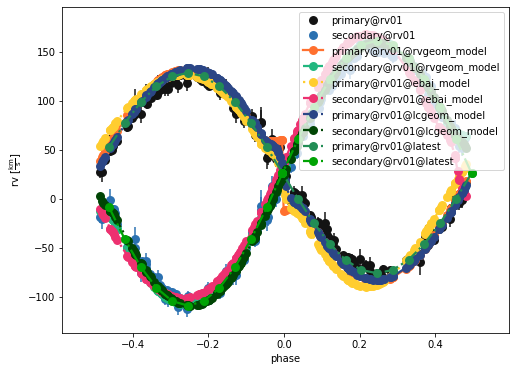

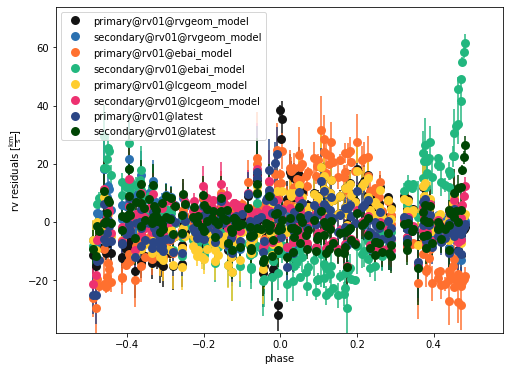

In [19]:
_ = b.plot(kind='rv', x='phases', show=True, legend=True, marker = 'o')
_ = b.plot(kind='rv', x='phases', y='residuals', show=True, legend=True, marker = 'o')

In [20]:
b.adopt_solution('nm_solution')

<ParameterSet: 22 parameters | contexts: dataset, component, system>

In [21]:
#fit lc
b.disable_dataset('rv01')
b.enable_dataset('lc01')

<ParameterSet: 18 parameters | components: binary, primary, secondary>

In [22]:
#Use our lc geometry solution to create compute phases that better sample the eclipses

edges = b.filter(solution='lcgeom_solution', qualifier='eclipse_edges')[0].value
#Define eclipse edges
edge_11 = edges[0]
edge_12 = edges[1]
edge_21 = 1.+edges[2]
edge_22 = edges[3]
#Define lc parts
#secondary eclipse part 1
ecs1 = np.linspace(-0.5, edge_22, 5) 
#out of eclipse from sec to prim
oec1 = np.linspace(edge_22+0.01, edge_11-0.01, 10) 
# primary eclipse
ecp = np.linspace(edge_11, edge_12, 10) 
#out of eclipse from prim to sec
oec2 = np.linspace(edge_12+0.01, edge_21-0.01, 10) 
#secondary eclipse part 2
ecs2 = np.linspace(edge_21, 0.5, 5) 

#put pieces back into a single array
comp_ph = np.hstack((ecs1, oec1,ecp, oec2, ecs2))


In [23]:
### set compute phases for lc
b.flip_constraint('compute_phases@lc01', solve_for='compute_times@lc01')

b.set_value_all('compute_phases', dataset='lc01', value=comp_ph)

In [24]:
#switch back from requivsumfrac to a primary radius
b.flip_constraint('requiv@primary', solve_for='requivsumfrac@binary')

#b.flip_constraint('requiv@secondary', solve_for='requivratio@binary')


<ConstraintParameter: {requivsumfrac@binary@component} = ({requiv@primary@component} + {requiv@secondary@component}) / {sma@binary@component} (solar units) => 0.34511581409961234>

In [25]:
fit_params = ['teffratio@binary', 't0_supconj@binary', 'incl@binary']#, 'requiv@primary', 'requivratio@binary']
b.set_value('fit_parameters', fit_params)

In [26]:
#change max iterations
b.set_value('maxiter', 20)

In [27]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [01:45<00:00,  5.26s/it]


<ParameterSet: 12 parameters | qualifiers: fitted_values, adopt_parameters, initial_values, fitted_units, adopt_distributions, comments, adopt_values, fitted_uniqueids, niter, fitted_twigs, message, success>

In [28]:
print(b.adopt_solution('nm_solution', trial_run=True))

ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.9187720459247655
   t0_supconj@binary@orbit@com...: 1.2338358146067652 d
      incl@binary@orbit@component: 83.74442758726912 deg


In [29]:
b.run_compute('nm_fit', solution='nm_solution', sample_num=1)

100%|██████████| 40/40 [00:00<00:00, 52.49it/s]


<ParameterSet: 9 parameters | qualifiers: sampled_uniqueids, comments, sampled_twigs, failed_samples, samples, times, flux_scale, fluxes, sample_mode>

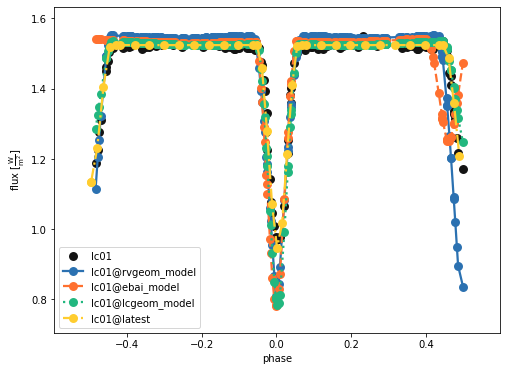

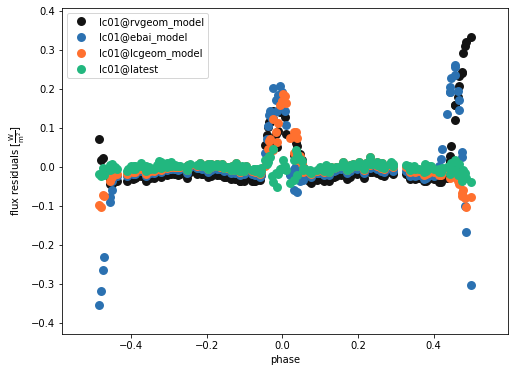

In [30]:
_ = b.plot(kind='lc', x='phases', show=True, legend=True, marker = 'o')
_ = b.plot(kind='lc', x='phases', y='residuals', show=True, legend=True, marker = 'o')

In [31]:
b.adopt_solution('nm_solution')

<ParameterSet: 24 parameters | contexts: component, dataset>

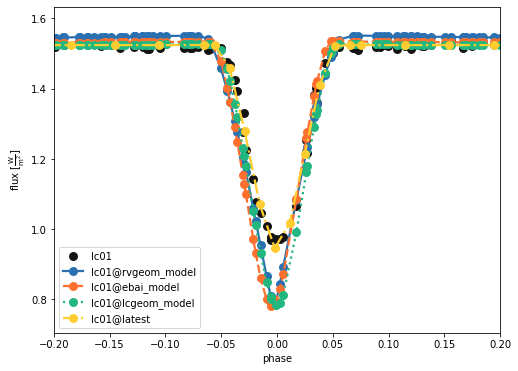

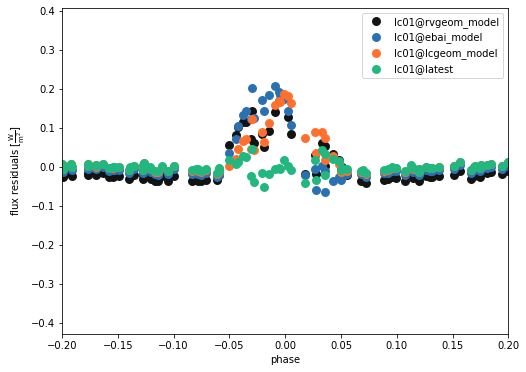

In [32]:
#look more closely at the primary eclipse
_ = b.plot(kind='lc', x='phases', xlim=[-0.2,0.2], show=True, legend=True, marker = 'o')
_ = b.plot(kind='lc', x='phases', xlim=[-0.2,0.2], y='residuals', show=True, legend=True, marker = 'o')

Exercise: Combine both light and rv curves to achieve a better fit, primarily within the eclipse. Hint: It's often better to fit a small number of parameters first. 

In [33]:
#add rv back 
b.enable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, primary, secondary>

In [34]:
fit_params = ['t0_supconj@binary', 'teffratio@binary', 'asini@binary', 'incl@binary']
b.set_value('fit_parameters', fit_params)

In [35]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [01:58<00:00,  5.94s/it]


<ParameterSet: 12 parameters | qualifiers: fitted_values, adopt_parameters, initial_values, fitted_units, adopt_distributions, comments, adopt_values, fitted_uniqueids, niter, fitted_twigs, message, success>

In [36]:
print(b.adopt_solution('nm_solution', trial_run=True))

ParameterSet: 4 parameters
   t0_supconj@binary@orbit@com...: 1.2308501058572388 d
   teffratio@binary@orbit@comp...: 0.9432403286266006
     asini@binary@orbit@component: 7.733947797809632 solRad
      incl@binary@orbit@component: 83.85148670110419 deg


In [37]:
b.run_compute('nm_fit', sample_from='nm_solution', sample_num=1)

100%|██████████| 64/64 [00:00<00:00, 76.69it/s]


<ParameterSet: 13 parameters | kinds: lc, rv>

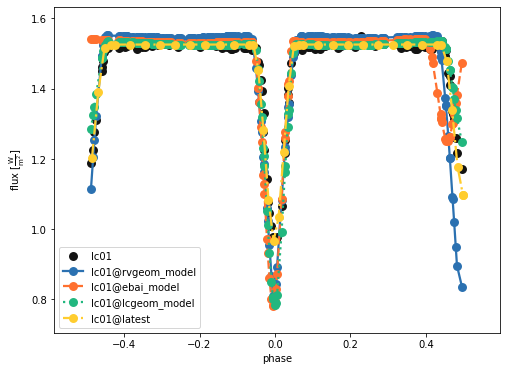

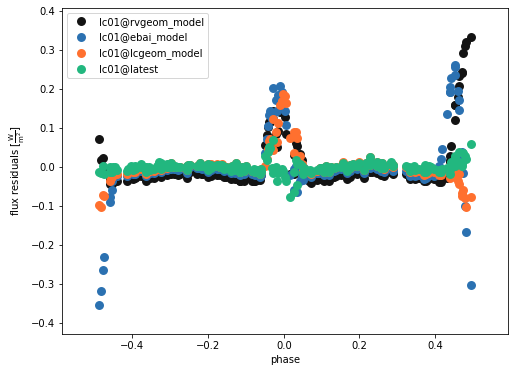

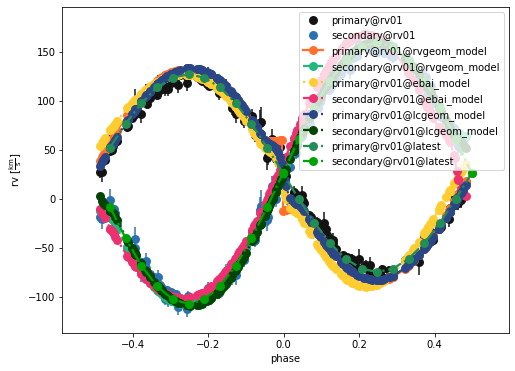

In [38]:
_ = b.plot(kind='lc', x='phases', show=True, legend=True, marker = 'o')
_ = b.plot(kind='lc', x='phases', y='residuals', show=True, legend=True, marker = 'o')
_ = b.plot(kind='rv', x='phases', show=True, legend=True, marker = 'o')

In [39]:
b.adopt_solution('nm_solution')

<ParameterSet: 25 parameters | contexts: component, dataset>

In [40]:
#Different set of parameters
fit_params = ['teffratio@binary', 'requiv@primary', 'requivratio@binary']
b.set_value('fit_parameters', fit_params)

In [41]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [01:53<00:00,  5.69s/it]


<ParameterSet: 12 parameters | qualifiers: fitted_values, adopt_parameters, initial_values, fitted_units, adopt_distributions, comments, adopt_values, fitted_uniqueids, niter, fitted_twigs, message, success>

In [42]:
print(b.adopt_solution('nm_solution', trial_run=True))

ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.9253032558087774
    requiv@primary@star@component: 1.278524732928571 solRad
   requivratio@binary@orbit@co...: 1.0818826670433095


In [43]:
b.run_compute('nm_fit', sample_from='nm_solution', sample_num=1)

100%|██████████| 64/64 [00:00<00:00, 75.45it/s]


<ParameterSet: 13 parameters | kinds: lc, rv>

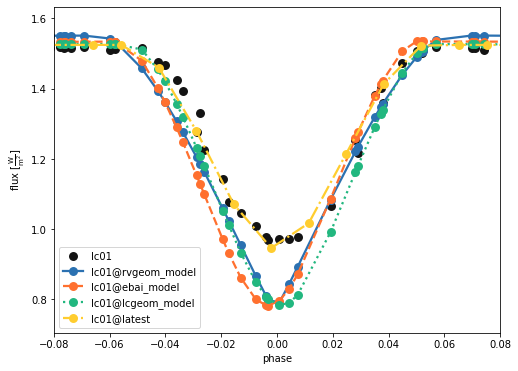

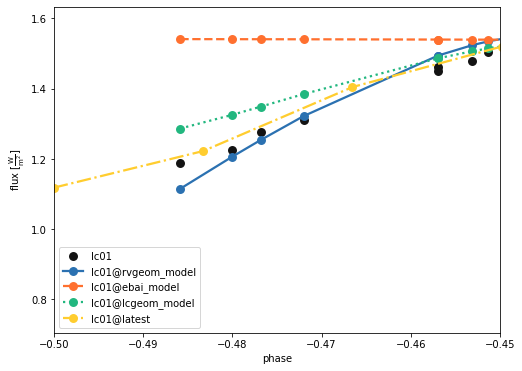

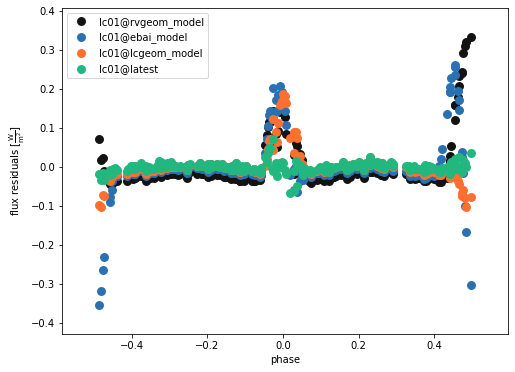

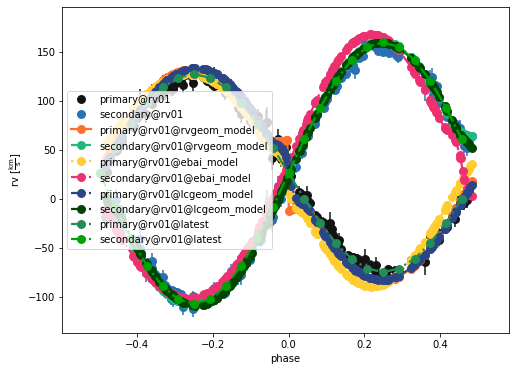

In [44]:
_ = b.plot(kind='lc', x='phases', xlim=[-0.08,0.08], show=True, legend=True, marker = 'o')
_ = b.plot(kind='lc', x='phases', xlim=[-0.5,-0.45], show=True, legend=True, marker = 'o')
_ = b.plot(kind='lc', x='phases', y='residuals', show=True, legend=True, marker = 'o')
_ = b.plot(kind='rv', x='phases', show=True, legend=True, marker = 'o')

In [45]:
b.adopt_solution('nm_solution')

<ParameterSet: 8 parameters | kinds: star, orbit>

In [46]:
b.save('data/synthetic/after_optimizers.bundle')

'data/synthetic/after_optimizers.bundle'